In [1]:
import tensorflow as tf
import tensorflow .contrib.slim as slim
import numpy as np
import random
from game_env import gameEnv
import os
import matplotlib.pyplot as plt
import scipy.misc

c:\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env = gameEnv(84,3)
env.drawGridState()
env.actions

12

In [3]:
class Qnetwork():
    def __init__(self,h_size):
        #Receives a (P,P,3) representation of the game, pixels x pixels by rgb,
        #specified when creating game environment
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])

        self.conv1 = slim.conv2d( \
            inputs=self.imageIn,num_outputs=32,kernel_size=[8,8],stride=[4,4],padding='VALID', biases_initializer=None)
        self.conv2 = slim.conv2d( \
            inputs=self.conv1,num_outputs=64,kernel_size=[4,4],stride=[2,2],padding='VALID', biases_initializer=None)
        self.conv3 = slim.conv2d( \
            inputs=self.conv2,num_outputs=64,kernel_size=[3,3],stride=[1,1],padding='VALID', biases_initializer=None)
        self.conv4 = slim.conv2d( \
            inputs=self.conv3,num_outputs=h_size,kernel_size=[7,7],stride=[1,1],padding='VALID', biases_initializer=None)
        
        
        
        #We take the output from the final convolutional layer and split it into separate advantage and value streams.
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        xavier_init = tf.contrib.layers.xavier_initializer()
        self.AW = tf.Variable(xavier_init([h_size//2,env.actions]))
        self.VW = tf.Variable(xavier_init([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [5]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [6]:
def processState(states):
    return np.reshape(states,[21168])

In [7]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
annealing_steps = 10000. #How many steps of training to reduce startE to endE.
num_episodes = 20000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
max_epLength = 50 #The max allowed length of our episode.
load_model = False #Whether to load a saved model.
path = "./dqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
tau = 0.001 #Rate to update target network toward primary network

In [8]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

e = startE
stepDrop = (startE - endE)/annealing_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    for i in range(num_episodes):
        episodeBuffer = experience_buffer()
        #Resetting env and getting first observation
        env.reset()
        s = env.reset()
        s = processState(s)

        d = env.game_over
        rAll = 0
        j = 0
        #The Q-Network
        #If agent takes longer than max episodes, end trial
        while j < max_epLength:
            j += 1
            #Choose action greedily(with e chance of random action) from Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,env.actions)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) 
            #Save the experience to our episode buffer.
            

            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Update the target network toward the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.ckpt')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.ckpt')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")
            
            
            
            
            
            
            

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Saved Model
171 -4.14 1
303 -3.4400000000000004 1
532 -5.300000000000001 1
718 -4.4399999999999995 1
936 -5.160000000000002 1
1223 -6.540000000000002 1
1355 -3.4400000000000004 1
1578 -5.18 1
1867 -6.500000000000002 1
2159 -6.4799999999999995 1
2305 -3.72 1
2502 -4.74 1
2741 -5.420000000000002 1
2900 -3.9800000000000013 1
3107 -4.94 1
3288 -4.420000000000001 1
3560 -6.0 1
3836 -6.08 1
4044 -4.880000000000001 1
4304 -6.000000000000002 1
4529 -5.220000000000001 1
4749 -5.040000000000001 1
4945 -4.720000000000001 1
5187 -5.360000000000001 1
5384 -4.66 1
5565 -4.340000000000001 1
5843 -6.280000000000001 1
6035 -4.5600000000000005 1
6200 -3.900000000000001 1
6421 -5.140000000000001 1
6588 -4.0600000000000005 1
6767 -4.3 1
6932 -4.1000000000000005 1
7250 -6.839999999999999 1
7372 -3.2399999999999998 1
7565 -4.660000000000001 1
7835 -6.120000000000002 1
8070 -5.339999999999999 1
8243 -4.260000000000001 1
8445 -4.84000000

45573 -0.8400000000000001 0.09999999999985551
45658 -0.7000000000000001 0.09999999999985551
45711 -0.25999999999999995 0.09999999999985551
45792 -0.42000000000000004 0.09999999999985551
45885 -0.6599999999999999 0.09999999999985551
45935 -0.4 0.09999999999985551
45999 -0.07999999999999999 0.09999999999985551
46071 -0.23999999999999994 0.09999999999985551
46154 -0.45999999999999985 0.09999999999985551
46245 -0.62 0.09999999999985551
46317 -0.24000000000000005 0.09999999999985551
46401 -0.6799999999999999 0.09999999999985551
46470 -0.17999999999999997 0.09999999999985551
46541 -0.21999999999999992 0.09999999999985551
46615 -0.27999999999999997 0.09999999999985551
46690 -1.1 0.09999999999985551
46747 -0.33999999999999997 0.09999999999985551
46818 -0.6199999999999999 0.09999999999985551
46902 -0.48 0.09999999999985551
46980 -0.36 0.09999999999985551
47052 -0.23999999999999994 0.09999999999985551
47127 -0.4999999999999999 0.09999999999985551
47206 -0.3799999999999999 0.09999999999985551
473

60801 -0.45999999999999996 0.09999999999985551
60890 -0.5800000000000001 0.09999999999985551
60962 -0.23999999999999994 0.09999999999985551
61080 -1.3600000000000005 0.09999999999985551
Saved Model
61146 -0.11999999999999997 0.09999999999985551
61223 -0.33999999999999986 0.09999999999985551
61295 -0.23999999999999994 0.09999999999985551
61363 -0.15999999999999998 0.09999999999985551
61447 -0.48000000000000026 0.09999999999985551
61525 -0.35999999999999993 0.09999999999985551
61601 -0.31999999999999995 0.09999999999985551
61678 -0.3399999999999999 0.09999999999985551
61756 -0.3599999999999999 0.09999999999985551
61822 -0.31999999999999995 0.09999999999985551
61897 -0.29999999999999993 0.09999999999985551
61969 -0.23999999999999994 0.09999999999985551
62047 -0.36 0.09999999999985551
62149 -0.8400000000000002 0.09999999999985551
62223 -0.27999999999999997 0.09999999999985551
62306 -0.45999999999999996 0.09999999999985551
62396 -0.6 0.09999999999985551
62484 -0.5600000000000002 0.099999999

75673 -0.54 0.09999999999985551
75760 -0.54 0.09999999999985551
75831 -0.21999999999999992 0.09999999999985551
75898 -0.33999999999999997 0.09999999999985551
75989 -0.6199999999999999 0.09999999999985551
76071 -0.43999999999999984 0.09999999999985551
76142 -0.21999999999999992 0.09999999999985551
76225 -0.4600000000000001 0.09999999999985551
76333 -0.9600000000000002 0.09999999999985551
76419 -0.72 0.09999999999985551
76509 -0.8 0.09999999999985551
76584 -0.29999999999999993 0.09999999999985551
76663 -0.38 0.09999999999985551
76747 -0.4800000000000001 0.09999999999985551
76823 -0.31999999999999995 0.09999999999985551
76907 -0.6799999999999999 0.09999999999985551
76977 -0.19999999999999998 0.09999999999985551
Saved Model
77055 -0.35999999999999993 0.09999999999985551
77128 -0.25999999999999995 0.09999999999985551
77214 -0.5200000000000001 0.09999999999985551
77288 -0.2799999999999999 0.09999999999985551
77361 -0.25999999999999995 0.09999999999985551
77434 -0.25999999999999995 0.09999999

89932 -0.5800000000000001 0.09999999999985551
90006 -0.2799999999999999 0.09999999999985551
90102 -0.9200000000000003 0.09999999999985551
90168 -0.11999999999999997 0.09999999999985551
90243 -0.4999999999999999 0.09999999999985551
90347 -0.8800000000000002 0.09999999999985551
90410 -0.059999999999999984 0.09999999999985551
90494 -0.48 0.09999999999985551
90566 -0.44000000000000006 0.09999999999985551
90638 -0.23999999999999994 0.09999999999985551
90718 -0.3999999999999998 0.09999999999985551
90789 -0.21999999999999997 0.09999999999985551
90864 -0.3 0.09999999999985551
90952 -0.7600000000000001 0.09999999999985551
91036 -0.47999999999999987 0.09999999999985551
91100 -0.07999999999999999 0.09999999999985551
91164 -0.07999999999999999 0.09999999999985551
91230 -0.12 0.09999999999985551
91327 -0.9400000000000001 0.09999999999985551
91406 -0.38 0.09999999999985551
91480 -0.2799999999999999 0.09999999999985551
91538 -0.15999999999999998 0.09999999999985551
91625 -0.5399999999999999 0.0999999

104110 -0.2799999999999999 0.09999999999985551
104172 -0.039999999999999994 0.09999999999985551
104244 -0.23999999999999994 0.09999999999985551
104308 -0.07999999999999999 0.09999999999985551
104393 -0.7000000000000001 0.09999999999985551
104473 -0.4000000000000001 0.09999999999985551
104576 -0.86 0.09999999999985551
104633 -0.13999999999999999 0.09999999999985551
104715 -0.43999999999999984 0.09999999999985551
104802 -0.54 0.09999999999985551
104881 -0.37999999999999995 0.09999999999985551
104959 -0.36 0.09999999999985551
105040 -0.6200000000000001 0.09999999999985551
105107 -0.33999999999999997 0.09999999999985551
105186 -0.3799999999999999 0.09999999999985551
105253 -0.13999999999999996 0.09999999999985551
105364 -1.02 0.09999999999985551
105453 -0.5800000000000001 0.09999999999985551
105546 -0.6600000000000001 0.09999999999985551
105627 -0.41999999999999993 0.09999999999985551
105715 -0.56 0.09999999999985551
105791 -0.31999999999999995 0.09999999999985551
105860 -0.379999999999999

118324 -0.6000000000000001 0.09999999999985551
118390 -0.11999999999999997 0.09999999999985551
118469 -0.3799999999999999 0.09999999999985551
118556 -0.5399999999999999 0.09999999999985551
118646 -0.5999999999999999 0.09999999999985551
118720 -0.48 0.09999999999985551
118812 -0.6399999999999999 0.09999999999985551
118888 -0.32 0.09999999999985551
118966 -0.35999999999999993 0.09999999999985551
119064 -0.7600000000000001 0.09999999999985551
119141 -0.34000000000000014 0.09999999999985551
119229 -0.5600000000000002 0.09999999999985551
119315 -0.5199999999999999 0.09999999999985551
119388 -0.2599999999999999 0.09999999999985551
119462 -0.27999999999999997 0.09999999999985551
119541 -0.38 0.09999999999985551
119615 -0.27999999999999997 0.09999999999985551
119689 -0.2799999999999999 0.09999999999985551
119765 -0.31999999999999995 0.09999999999985551
119849 -0.4800000000000001 0.09999999999985551
119919 -0.19999999999999996 0.09999999999985551
119993 -0.2800000000000001 0.09999999999985551
1

132656 -0.07999999999999999 0.09999999999985551
132751 -0.7000000000000002 0.09999999999985551
132817 -0.11999999999999997 0.09999999999985551
132890 -0.25999999999999995 0.09999999999985551
132970 -0.4000000000000001 0.09999999999985551
133048 -0.35999999999999993 0.09999999999985551
133127 -0.5799999999999998 0.09999999999985551
133191 -0.27999999999999997 0.09999999999985551
133260 -0.17999999999999997 0.09999999999985551
133339 -0.3799999999999999 0.09999999999985551
133415 -0.31999999999999995 0.09999999999985551
133482 -0.13999999999999996 0.09999999999985551
133560 -0.5599999999999999 0.09999999999985551
133630 -0.19999999999999996 0.09999999999985551
133706 -0.5200000000000001 0.09999999999985551
133801 -0.7000000000000002 0.09999999999985551
133882 -0.41999999999999993 0.09999999999985551
133971 -0.58 0.09999999999985551
134051 -0.39999999999999997 0.09999999999985551
134141 -0.5999999999999999 0.09999999999985551
134221 -0.4 0.09999999999985551
134288 -0.5399999999999999 0.09

147048 0.039999999999999994 0.09999999999985551
147128 -0.3999999999999999 0.09999999999985551
147201 -0.25999999999999995 0.09999999999985551
147294 -0.6599999999999999 0.09999999999985551
147376 -0.43999999999999995 0.09999999999985551
147455 -0.37999999999999995 0.09999999999985551
147539 -0.47999999999999987 0.09999999999985551
147620 -0.6199999999999999 0.09999999999985551
147691 -0.21999999999999992 0.09999999999985551
147765 -0.2799999999999999 0.09999999999985551
147826 -0.21999999999999992 0.09999999999985551
147923 -0.74 0.09999999999985551
148006 -0.45999999999999996 0.09999999999985551
148087 -0.41999999999999993 0.09999999999985551
148172 -0.5000000000000002 0.09999999999985551
148233 -0.019999999999999997 0.09999999999985551
148293 -0.2 0.09999999999985551
148370 -0.33999999999999986 0.09999999999985551
148452 -0.44000000000000006 0.09999999999985551
148551 -0.78 0.09999999999985551
148631 -0.4000000000000001 0.09999999999985551
148710 -0.38 0.09999999999985551
148785 -0.

161286 -0.15999999999999998 0.09999999999985551
161381 -0.9000000000000001 0.09999999999985551
161454 -0.2599999999999999 0.09999999999985551
161518 -0.07999999999999999 0.09999999999985551
161595 -0.33999999999999997 0.09999999999985551
161680 -0.7000000000000001 0.09999999999985551
161749 -0.17999999999999997 0.09999999999985551
161818 -0.17999999999999997 0.09999999999985551
161904 -0.5199999999999999 0.09999999999985551
161992 -0.5599999999999999 0.09999999999985551
162065 -0.25999999999999995 0.09999999999985551
162136 -0.21999999999999992 0.09999999999985551
Saved Model
162209 -0.45999999999999996 0.09999999999985551
162279 -0.19999999999999996 0.09999999999985551
162371 -0.6400000000000002 0.09999999999985551
162439 -0.36 0.09999999999985551
162550 -1.0200000000000002 0.09999999999985551
162629 -0.38 0.09999999999985551
162701 -0.23999999999999994 0.09999999999985551
162771 -0.4 0.09999999999985551
162839 -0.15999999999999998 0.09999999999985551
162909 -0.19999999999999993 0.099

175194 -0.13999999999999996 0.09999999999985551
175263 -0.38 0.09999999999985551
175349 -0.5200000000000001 0.09999999999985551
175447 -0.7600000000000002 0.09999999999985551
175526 -0.5799999999999998 0.09999999999985551
175597 -0.21999999999999992 0.09999999999985551
175682 -0.7 0.09999999999985551
175757 -0.29999999999999993 0.09999999999985551
175836 -0.38 0.09999999999985551
175927 -0.6200000000000001 0.09999999999985551
176025 -0.76 0.09999999999985551
176106 -0.41999999999999993 0.09999999999985551
176181 -0.29999999999999993 0.09999999999985551
176260 -0.37999999999999995 0.09999999999985551
176334 -0.2799999999999999 0.09999999999985551
176425 -0.6199999999999999 0.09999999999985551
176491 -0.11999999999999997 0.09999999999985551
176580 -0.5800000000000001 0.09999999999985551
176654 -0.2799999999999999 0.09999999999985551
176721 -0.14 0.09999999999985551
176791 -0.20000000000000004 0.09999999999985551
176868 -0.33999999999999997 0.09999999999985551
176951 -0.45999999999999996 

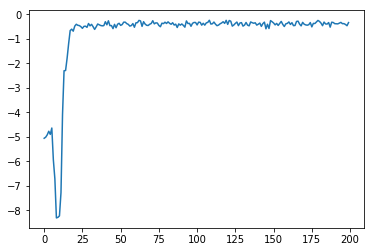

In [9]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)